In [2]:
import sys
sys.path.append("../")
from Functions.csv_files.stock import Stock

In [3]:
apple = Stock('AAPL.US', filepath="../Functions/csv_files/")

In [4]:
apple.retrieve_data()

,date,close,volume,3 Month Treasury Yield,WTI Crude Oil Prices,7-day volatility,7-day EWM,7-rsi,7-day slope,14-day volatility,14-day EWM,14-rsi,14-day slope
0,1980-12-12,28.7392,469033600,16.55,NaN,NaN,28.739200,NaN,NaN,NaN,28.739200,NaN,NaN
1,1980-12-15,27.2608,175884800,16.77,NaN,NaN,28.369600,NaN,NaN,NaN,28.542080,NaN,NaN
2,1980-12-16,25.2448,105728000,16.70,NaN,NaN,27.588400,NaN,NaN,NaN,28.102443,NaN,NaN
3,1980-12-17,25.8720,86441600,16.47,NaN,NaN,27.159300,NaN,NaN,NaN,27.805050,NaN,NaN
4,1980-12-18,26.6336,73449600,16.20,NaN,NaN,27.027875,NaN,NaN,NaN,27.648857,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10598,2022-12-23,131.8600,63814900,4.23,79.57,29.533940,134.509237,133.602857,-0.550000,82.490509,137.503068,138.360714,-1.040593
10599,2022-12-27,130.0300,69007800,4.35,79.45,28.367354,133.389428,132.678571,-0.518929,86.712790,136.506659,137.440714,-1.128637
10600,2022-12-28,126.0400,85438400,4.35,78.89,45.654730,131.552071,131.468571,-0.968571,97.436570,135.111104,136.376429,-1.339011
10601,2022-12-29,129.6100,75703700,4.34,78.43,46.363788,131.066553,131.074286,-1.038929,96.866017,134.377624,135.445000,-1.325516


In [5]:
def split(dataframe, window, columns = None, test_split = False):
  X = []
  y_raw = []
  y_label = []
  if columns is not None:
    dataframe = dataframe[columns]
  dataframe = dataframe.dropna()
  dataframe = dataframe.drop(columns=['date']).reset_index(drop=True)
  L = len(dataframe)
  
  for i in range(0, L):
    if i > (L - window - 1):
      break
    X.append(dataframe[i:(i + window)])
    label = dataframe['close'][i + window]
    last = dataframe['close'][i + window - 1]
    y_raw.append(label)
    if label <= last:
      y_label.append(0)
    else:
      y_label.append(1)
      
  if test_split:
    """
    We can't shuffle split here because in LSTM we are using return_sequence = True
    """
    print("Todo")
    

      
  
  return X, y_raw, y_label

In [6]:
apple.data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10603 entries, 0 to 10602
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    10603 non-null  object 
 1   close                   10603 non-null  float64
 2   volume                  10603 non-null  int64  
 3   3 Month Treasury Yield  10503 non-null  float64
 4   WTI Crude Oil Prices    9293 non-null   float64
 5   7-day volatility        10597 non-null  float64
 6   7-day EWM               10603 non-null  float64
 7   7-rsi                   10597 non-null  float64
 8   7-day slope             10597 non-null  float64
 9   14-day volatility       10590 non-null  float64
 10  14-day EWM              10603 non-null  float64
 11  14-rsi                  10590 non-null  float64
 12  14-day slope            10590 non-null  float64
dtypes: float64(11), int64(1), object(1)
memory usage: 1.1+ MB


In [7]:
X, y_raw, y_label = split(apple.data, 7)

In [8]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import keras
import numpy as np
import lstm_utils
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [15]:
train_X_control = np.array(X)
train_X_control = train_X_control[:,:,0].reshape(-1, 7, 1)
train_y_raw = np.array(y_raw)
train_y_label = np.array(y_label)

train_X_control = train_X_control.astype('float32')
print(train_X_control.shape)
print(train_y_raw.shape)
print(train_y_label.shape)

(9207, 7, 1)
(9207,)
(9207,)


<h1>Control Model 1</h1>
This model takes in data and outputs a binary output of 0 and 1.

<h2>Min Max Scaled</h2>

In [17]:
train_X_control_1a = []

for i in train_X_control:
    train_X_control_1a.append(lstm_utils.scale_column(i))
    
train_X_control_1a = np.array(train_X_control_1)

In [18]:
control_model_1a = keras.Sequential()
control_model_1a.add(LSTM(20, return_sequences=True, input_shape=(7, 1)))
control_model_1a.add(Dropout(0.2))
control_model_1a.add(LSTM(10, return_sequences=False, input_shape=(7, 1)))
control_model_1a.add(Dense(25))
control_model_1a.add(Dense(1))
control_model_1a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 20)             1760      
                                                                 
 dropout_1 (Dropout)         (None, 7, 20)             0         
                                                                 
 lstm_3 (LSTM)               (None, 10)                1240      
                                                                 
 dense_2 (Dense)             (None, 25)                275       
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 3,301
Trainable params: 3,301
Non-trainable params: 0
_________________________________________________________________


In [19]:
control_model_1a.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [21]:
control_model_1a_history = control_model_1a.fit(train_X_control_1a, train_y_label, batch_size= 32, epochs=15)

Epoch 1/15
288/288 [==============================] - 7s 9ms/step - loss: 0.8665 - acc: 0.4921
Epoch 2/15
288/288 [==============================] - 3s 9ms/step - loss: 0.6970 - acc: 0.4997
Epoch 3/15
288/288 [==============================] - 3s 9ms/step - loss: 0.6950 - acc: 0.5065
Epoch 4/15
288/288 [==============================] - 3s 9ms/step - loss: 0.6951 - acc: 0.4935
Epoch 5/15
288/288 [==============================] - 3s 9ms/step - loss: 0.6947 - acc: 0.5053
Epoch 6/15
288/288 [==============================] - 3s 9ms/step - loss: 0.6949 - acc: 0.4993
Epoch 7/15
288/288 [==============================] - 3s 9ms/step - loss: 0.6940 - acc: 0.4978
Epoch 8/15
288/288 [==============================] - 3s 10ms/step - loss: 0.6946 - acc: 0.4893
Epoch 9/15
288/288 [==============================] - 3s 9ms/step - loss: 0.6950 - acc: 0.4979
Epoch 10/15
288/288 [==============================] - 3s 9ms/step - loss: 0.6948 - acc: 0.4971
Epoch 11/15
288/288 [===========================

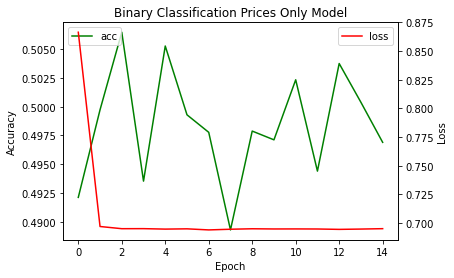

In [22]:
lstm_utils.plot_history(control_model_1a_history, "Binary Classification Prices Only Model")

In [23]:
def summarize_results(model, data, y = None):
  predicted = model.predict(data)
  if y is not None:
    actual = y.reshape(-1, 1)
    plt.plot(actual, label = 'actual', color='red')
  plt.plot(predicted, label = 'predicted', color = 'green')
  plt.show()
  return predicted

288/288 [==============================] - 1s 4ms/step


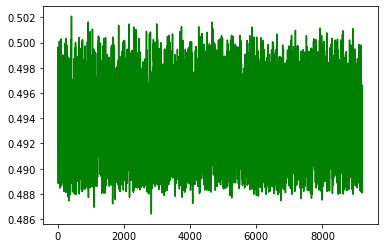

array([[0.4981058 ],
       [0.4942775 ],
       [0.49378282],
       ...,
       [0.49206725],
       [0.4909242 ],
       [0.48992404]], dtype=float32)

In [25]:
summarize_results(control_model_1a, train_X_control_1a)

In [26]:
def classify_accuracy(model, x, y):
  prediction = [1 if i > 0.5 else 0 for i in model.predict(x)[:, 0]]
  correct = 0
  for index, val in enumerate(prediction): 
    if val == y[index]:
      correct += 1
      
  print(correct/len(y))
  return prediction

In [28]:
classify_accuracy(control_model_1a, train_X_control_1a, y_label)

288/288 [==============================] - 1s 4ms/step
0.4999456934940806


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,


<h2> No scaling</h2>

In [29]:
control_model_1b = keras.Sequential()
control_model_1b.add(LSTM(20, return_sequences=True, input_shape=(7, 1)))
control_model_1b.add(Dropout(0.2))
control_model_1b.add(LSTM(10, return_sequences=False, input_shape=(7, 1)))
control_model_1b.add(Dense(25))
control_model_1b.add(Dense(1))
control_model_1b.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 7, 20)             1760      
                                                                 
 dropout_2 (Dropout)         (None, 7, 20)             0         
                                                                 
 lstm_5 (LSTM)               (None, 10)                1240      
                                                                 
 dense_4 (Dense)             (None, 25)                275       
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 3,301
Trainable params: 3,301
Non-trainable params: 0
_________________________________________________________________


In [30]:
control_model_1b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [31]:
control_model_1b_history = control_model_1b.fit(train_X_control, train_y_label, batch_size= 32, epochs=15)

Epoch 1/15
288/288 [==============================] - 7s 9ms/step - loss: 0.7459 - acc: 0.5024
Epoch 2/15
288/288 [==============================] - 3s 10ms/step - loss: 0.6957 - acc: 0.5068
Epoch 3/15
288/288 [==============================] - 3s 9ms/step - loss: 0.6953 - acc: 0.5079
Epoch 4/15
288/288 [==============================] - 3s 9ms/step - loss: 0.6940 - acc: 0.5112
Epoch 5/15
288/288 [==============================] - 4s 13ms/step - loss: 0.6940 - acc: 0.5102
Epoch 6/15
288/288 [==============================] - 4s 13ms/step - loss: 0.6939 - acc: 0.5103
Epoch 7/15
288/288 [==============================] - 3s 12ms/step - loss: 0.6942 - acc: 0.5104
Epoch 8/15
288/288 [==============================] - 3s 11ms/step - loss: 0.6939 - acc: 0.5105
Epoch 9/15
288/288 [==============================] - 3s 10ms/step - loss: 0.6940 - acc: 0.5098
Epoch 10/15
288/288 [==============================] - 3s 10ms/step - loss: 0.6934 - acc: 0.5127
Epoch 11/15
288/288 [=====================

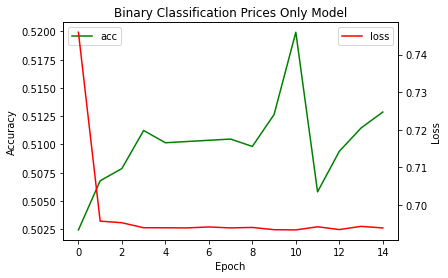

In [32]:
lstm_utils.plot_history(control_model_1b_history, "Binary Classification Prices Only Model")

288/288 [==============================] - 2s 4ms/step


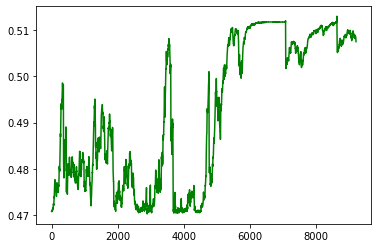

array([[0.47081637],
       [0.47081584],
       [0.4708271 ],
       ...,
       [0.5076435 ],
       [0.5075248 ],
       [0.5074579 ]], dtype=float32)

In [33]:
summarize_results(control_model_1b, train_X_control)

In [34]:
classify_accuracy(control_model_1b, train_X_control, y_label)

288/288 [==============================] - 1s 4ms/step
0.5221027479091995


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


<h1>MSE Model</h1>

In [80]:
control_model_2 = keras.Sequential()
control_model_2.add(LSTM(20, return_sequences=True, input_shape=(7, 1)))
control_model_2.add(Dropout(0.2))
control_model_2.add(LSTM(10, return_sequences=False, input_shape=(7, 1)))
control_model_2.add(Dense(25))
control_model_2.add(Dense(1))
control_model_2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 7, 20)             1760      
                                                                 
 dropout_13 (Dropout)        (None, 7, 20)             0         
                                                                 
 lstm_27 (LSTM)              (None, 10)                1240      
                                                                 
 dense_26 (Dense)            (None, 25)                275       
                                                                 
 dense_27 (Dense)            (None, 1)                 26        
                                                                 
Total params: 3,301
Trainable params: 3,301
Non-trainable params: 0
_________________________________________________________________


In [81]:
control_model_2.compile(optimizer='adam', loss='mean_squared_error')

In [82]:
control_model_2_history = control_model_2.fit(train_X_control, train_y_raw, epochs=15, validation_split=0.2)

Epoch 1/15
231/231 [==============================] - 9s 18ms/step - loss: 31191.6582 - val_loss: 19776.6289
Epoch 2/15
231/231 [==============================] - 3s 12ms/step - loss: 21210.0469 - val_loss: 5705.9536
Epoch 3/15
231/231 [==============================] - 2s 11ms/step - loss: 11811.7422 - val_loss: 1264.9054
Epoch 4/15
231/231 [==============================] - 3s 12ms/step - loss: 5654.6377 - val_loss: 362.6019
Epoch 5/15
231/231 [==============================] - 3s 14ms/step - loss: 2533.4058 - val_loss: 205.0882
Epoch 6/15
231/231 [==============================] - 3s 11ms/step - loss: 1164.2150 - val_loss: 480.9588
Epoch 7/15
231/231 [==============================] - 3s 11ms/step - loss: 613.2444 - val_loss: 151.9633
Epoch 8/15
231/231 [==============================] - 3s 12ms/step - loss: 371.4013 - val_loss: 253.8083
Epoch 9/15
231/231 [==============================] - 3s 13ms/step - loss: 299.4029 - val_loss: 348.3683
Epoch 10/15
231/231 [=====================

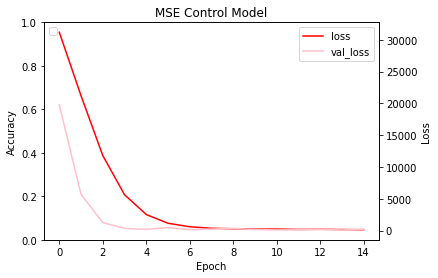

In [83]:
lstm_utils.plot_history(control_model_2_history, "MSE Control Model")

288/288 [==============================] - 3s 5ms/step


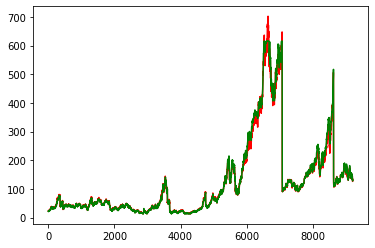

array([[ 21.584988],
       [ 21.580595],
       [ 21.788805],
       ...,
       [130.96199 ],
       [127.511116],
       [129.42761 ]], dtype=float32)

In [84]:
summarize_results(control_model_2, train_X_control, train_y_raw)

In [49]:
s = np.array([train_X_control[9000], ])
print(s.shape)
print(control_model_2.predict(s))

(1, 7, 1)
1/1 [==============================] - 0s 48ms/step
[[161.13617]]


<h1>Model 1 - 3M yield and WTI Prices</h1>

In [85]:
df = apple.data[['date', 'close', '3 Month Treasury Yield', 'WTI Crude Oil Prices']]
X, y_raw, y_label = split(df, 7)
train_X_1 = np.array(X)
train_X_1 = train_X_1.astype('float32')
train_X_1.shape

(9207, 7, 3)

In [95]:
model_1 = keras.Sequential()
model_1.add(LSTM(20, return_sequences=True, input_shape=(7, 3)))
model_1.add(Dropout(0.2))
model_1.add(LSTM(10, return_sequences=False, input_shape=(7, 3)))
model_1.add(Dense(25))
model_1.add(Dense(1))
model_1.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 7, 20)             1920      
                                                                 
 dropout_15 (Dropout)        (None, 7, 20)             0         
                                                                 
 lstm_31 (LSTM)              (None, 10)                1240      
                                                                 
 dense_30 (Dense)            (None, 25)                275       
                                                                 
 dense_31 (Dense)            (None, 1)                 26        
                                                                 
Total params: 3,461
Trainable params: 3,461
Non-trainable params: 0
_________________________________________________________________


In [96]:
model_1.compile(optimizer='adam', loss='mean_squared_error')

In [104]:
model_1_history = model_1.fit(train_X_1, train_y_raw, batch_size= 32, epochs=10, validation_split=0.2)

Epoch 1/10
231/231 [==============================] - 3s 15ms/step - loss: 180.1477 - val_loss: 1514.0112
Epoch 2/10
231/231 [==============================] - 3s 13ms/step - loss: 211.2032 - val_loss: 1718.6674
Epoch 3/10
231/231 [==============================] - 3s 11ms/step - loss: 184.2153 - val_loss: 2136.0586
Epoch 4/10
231/231 [==============================] - 3s 12ms/step - loss: 155.3698 - val_loss: 1403.2827
Epoch 5/10
231/231 [==============================] - 3s 13ms/step - loss: 165.4612 - val_loss: 1206.3251
Epoch 6/10
231/231 [==============================] - 3s 12ms/step - loss: 151.7812 - val_loss: 896.3923
Epoch 7/10
231/231 [==============================] - 3s 11ms/step - loss: 150.4317 - val_loss: 822.7769
Epoch 8/10
231/231 [==============================] - 3s 12ms/step - loss: 144.4808 - val_loss: 657.6010
Epoch 9/10
231/231 [==============================] - 3s 13ms/step - loss: 125.7614 - val_loss: 981.1934
Epoch 10/10
231/231 [=============================

In [105]:
s = np.array([train_X_1[9000], ])
print(s.shape)
print(model_1.predict(s))

(1, 7, 3)
1/1 [==============================] - 0s 45ms/step
[[152.70583]]


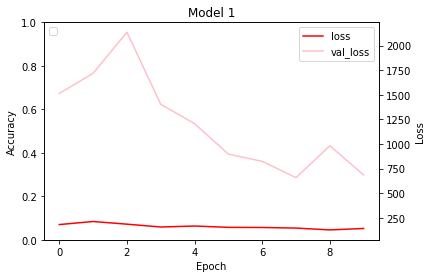

In [106]:
lstm_utils.plot_history(model_1_history, "Model 1")

288/288 [==============================] - 1s 5ms/step


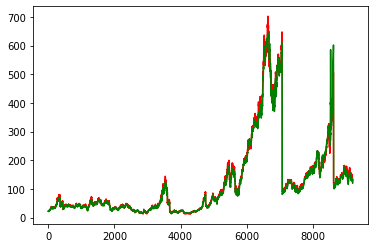

array([[ 21.691626],
       [ 21.782528],
       [ 21.8969  ],
       ...,
       [121.616905],
       [119.9107  ],
       [120.51471 ]], dtype=float32)

In [107]:
summarize_results(model_1, train_X_1, train_y_raw)

In [108]:
model_1.save("Model_1")

INFO:tensorflow:Assets written to: Model_1\assets


INFO:tensorflow:Assets written to: Model_1\assets


Model 2 - 

In [ ]:
model

In [ ]:
df = apple.data[['date', 'close', '3 Month Treasury Yield', 'WTI Crude Oil Prices', '7-day slope', '7-rsi']]
X, y_raw, y_label = split(df, 7)
train_X = np.array(X)
train_X = train_X.astype('float32')

train_y = np.array(train_y)
train_X.shape

In [ ]:
model = Sequential()

model.add(LSTM(units=32, return_sequences=True, input_shape=(7, 5)))
model.add(keras.layers.Dropout(0.2))
model.add(LSTM(units=16))
model.add(keras.layers.Dropout(0.2))
model.add(Dense(8))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(train_X, train_y, epochs=30, verbose=1, validation_split=0.2)

In [ ]:
lstm_utils.plot_history(history, "Model")